# Reversal / Momentum - Time Horizon
In this homework, we explore how reversal tends to exist at shorter horizons and momentum at longer horizons. We do this on 4h cryptocurrency price data. Please first run the code below, which will download the price data (from Binance since 01/2020 to 12/2022) and compute returns based on it, stored in `ret`.

1. Use `ret` to generate rank-demeaned-normalized XS reversal strategies at 4,8,12,16,20, and 24 hour frequencies.
2. IE. for the 12 hour strategy, you will use the average return in the last three 4-hour bars to form a rank-demeaned-noramlzied XS portfolio and hold for the 4 hours.

In [ ]:
from binance.client import Client as bnb_client
import datetime
import pandas as pd 
import numpy as np 

# client = bnb_client()
###  if you're in the US, use: 
# "client = bnb_client(tld='US')" here instead

client = bnb_client(tld='US')

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    data['close_time'] = data['close_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

C:\Users\joshu\AppData\Local\Temp\ipykernel_22360\3053184624.py:34: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [53]:
def simulate(time_horizon):
    adj_ret = ret.rolling(time_horizon).mean()
    adj_ret = adj_ret.rank(1).apply(lambda x: -x + x.mean(),axis=1)
    adj_ret = adj_ret / adj_ret.abs().sum(1).values.reshape(-1,1)
    adj_ret = adj_ret.shift(1)
    return (adj_ret * ret).sum(1)
simulate(2)

2020-01-01 00:00:00+00:00    0.000000
2020-01-01 04:00:00+00:00    0.000000
2020-01-01 08:00:00+00:00    0.000000
2020-01-01 12:00:00+00:00   -0.001558
2020-01-01 16:00:00+00:00   -0.000616
                               ...   
2025-01-02 04:00:00+00:00    0.011166
2025-01-02 08:00:00+00:00   -0.000629
2025-01-02 12:00:00+00:00    0.002926
2025-01-02 16:00:00+00:00    0.001063
2025-01-02 20:00:00+00:00   -0.000614
Freq: 4h, Length: 10974, dtype: float64

3. Compute the Sharpe ratios of the reversal strategy at these different horizons.

Time Horizon: 4 hours
Sharpe Ratio:  2.330771652774105
Time Horizon: 8 hours
Sharpe Ratio:  0.45773384708121706
Time Horizon: 12 hours
Sharpe Ratio:  -0.2399052936787292
Time Horizon: 16 hours
Sharpe Ratio:  -0.38891025883795505
Time Horizon: 20 hours
Sharpe Ratio:  -0.2876446170649029
Time Horizon: 24 hours
Sharpe Ratio:  -0.010857407243416904


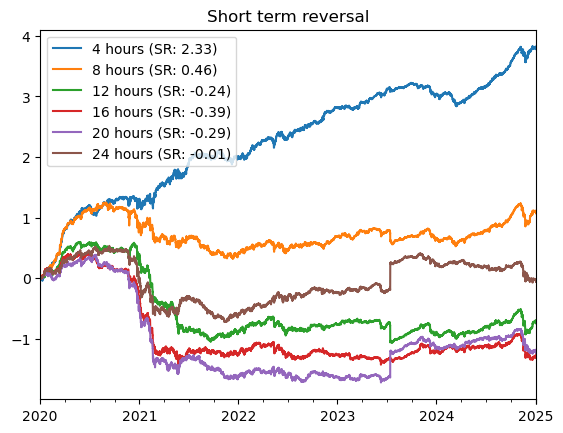

In [54]:
import matplotlib.pyplot as plt
for i in range(1, 7):
    print(f"Time Horizon: {4*i} hours")
    sim_ret = simulate(i)

    sharpe = sim_ret.mean()/sim_ret.std() * np.sqrt(6/i*365) 
    print("Sharpe Ratio: ", sharpe)

    sim_ret.cumsum().plot(label = f"{4*i} hours (SR: {sharpe:.2f})")
    #label legend
    plt.legend()
plt.title("Short term reversal")
plt.show()

4. At what horizons do you observe reversal vs. momentum?

Momentum at 12-20, and reversal at 4 and 8. Strong at 4.


5. The first bar typically contains the most reversal. "Skip" the first bar by lagging your portfolio by one 4h bar (similar to how UMD does at the monthly frequency). This should strengthen any momentum you see.

Time Horizon: 4 hours
Sharpe Ratio:  0.7627853105414252
Time Horizon: 8 hours
Sharpe Ratio:  1.0678174567276517
Time Horizon: 12 hours
Sharpe Ratio:  0.8958888632743
Time Horizon: 16 hours
Sharpe Ratio:  0.488490564684854
Time Horizon: 20 hours
Sharpe Ratio:  0.17521347326042586
Time Horizon: 24 hours
Sharpe Ratio:  0.19659576922461414


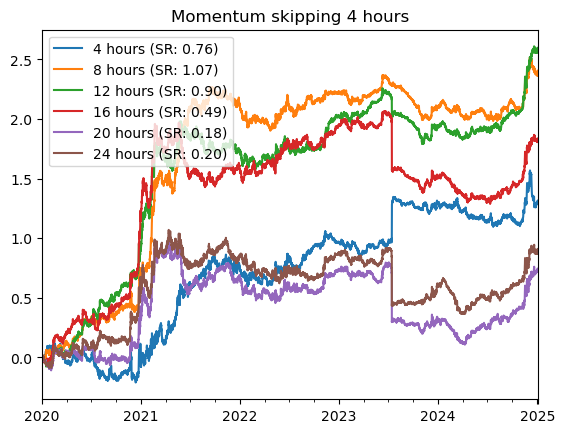

In [57]:
def simulate_momentum(time_horizon):
    adj_ret = ret.rolling(time_horizon).mean()
    adj_ret = adj_ret.rank(1).apply(lambda x: x - x.mean(),axis=1)
    adj_ret = adj_ret / adj_ret.abs().sum(1).values.reshape(-1,1)
    adj_ret = adj_ret.shift(2)
    return (adj_ret * ret).sum(1)

for i in range(1, 7):
    print(f"Time Horizon: {4*i} hours")
    sim_ret = simulate_momentum(i)

    sharpe = sim_ret.mean()/sim_ret.std() * np.sqrt(6/i*365) 
    print("Sharpe Ratio: ", sharpe)

    sim_ret.cumsum().plot(label = f"{4*i} hours (SR: {sharpe:.2f})")
    #label legend
    plt.legend()
plt.title("Momentum skipping 4 hours")
plt.show()